In [15]:
pip install pandas numpy faker


In [16]:
pip install joblib

In [17]:
import pandas as pd
import numpy as np
from faker import Faker
from random import randint, choice, uniform
import datetime

fake = Faker()
np.random.seed(42)

def simulate_upi_transactions(n=10000, fraud_ratio=0.05):
    upi_data = []
    for i in range(n):
        is_fraud = np.random.rand() < fraud_ratio
        sender = fake.uuid4()
        receiver = fake.uuid4()
        amount = round(uniform(10, 10000), 2) if not is_fraud else round(uniform(5000, 100000), 2)
        txn_type = choice(['P2P', 'P2M', 'QR', 'BillPay'])
        txn_status = choice(['SUCCESS', 'FAILED', 'PENDING']) if not is_fraud else choice(['FAILED', 'SUCCESS'])
        device_id = fake.uuid4()
        ip = fake.ipv4_public()
        location = fake.city()
        txn_time = fake.date_time_this_year()
        merchant_code = fake.bothify(text='M####')
        fraud_flag = 1 if is_fraud else 0

        upi_data.append([
            txn_time, sender, receiver, amount, txn_type, txn_status,
            device_id, ip, location, merchant_code, fraud_flag
        ])

    columns = [
        'timestamp', 'sender_id', 'receiver_id', 'amount', 'txn_type', 'txn_status',
        'device_id', 'ip_address', 'location', 'merchant_code', 'is_fraud'
    ]
    return pd.DataFrame(upi_data, columns=columns)

def simulate_voip_calls(n=5000, fraud_ratio=0.1):
    voip_data = []
    known_spam_numbers = [fake.phone_number() for _ in range(20)]

    for i in range(n):
        is_fraud = np.random.rand() < fraud_ratio
        caller = fake.phone_number() if not is_fraud else choice(known_spam_numbers)
        receiver = fake.phone_number()
        duration = randint(1, 600) if not is_fraud else randint(1, 10)  # very short duration for fraud
        call_time = fake.date_time_this_year()
        voip_provider = choice(['JioCall', 'WhatsApp', 'Skype', 'Zoom', 'GoogleVoice'])
        geo_info = fake.city()
        spoof_flag = 1 if is_fraud and np.random.rand() < 0.5 else 0
        fraud_flag = 1 if is_fraud else 0

        voip_data.append([
            call_time, caller, receiver, duration, voip_provider, geo_info, spoof_flag, fraud_flag
        ])

    columns = [
        'call_time', 'caller_number', 'receiver_number', 'call_duration',
        'voip_provider', 'geo_info', 'spoof_flag', 'is_fraud'
    ]
    return pd.DataFrame(voip_data, columns=columns)

# Generate datasets
upi_df = simulate_upi_transactions(n=10000, fraud_ratio=0.05)
voip_df = simulate_voip_calls(n=5000, fraud_ratio=0.1)

# Save to CSV
upi_df.to_csv("simulated_upi_transactions.csv", index=False)
voip_df.to_csv("simulated_voip_calls.csv", index=False)

print("✅ Synthetic datasets generated and saved!")


✅ Synthetic datasets generated and saved!


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Load UPI dataset
df = pd.read_csv("simulated_upi_transactions.csv")

# Step 2: Basic preprocessing
categorical_cols = ['txn_type', 'txn_status', 'location', 'merchant_code']
df[categorical_cols] = df[categorical_cols].astype(str)

#Step 3: Encode categorical UPI columns
upi_encoders = {}
for col in ['txn_type', 'txn_status', 'location', 'merchant_code']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    upi_encoders[col] = le


# Step 4: Feature selection
features = ['amount', 'txn_type', 'txn_status', 'location', 'merchant_code']
X = df[features]
y = df['is_fraud']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Step 6: Train LightGBM model
upi_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
upi_model.fit(X_train, y_train)

# Step 7: Evaluation
y_pred = upi_model.predict(X_test)
y_proba = upi_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


[LightGBM] [Info] Number of positive: 370, number of negative: 7130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049333 -> initscore=-2.958564
[LightGBM] [Info] Start training from score -2.958564
Confusion Matrix:
 [[2377    0]
 [   8  115]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2377
           1       1.00      0.93      0.97       123

    accuracy                           1.00      2500
   macro avg       1.00      0.97      0.98      2500
weighted avg       1.00      1.00      1.00      2500


ROC AUC Score: 0.985190049628725


In [20]:
# Save UPI model and encoders
import joblib
joblib.dump(upi_model, "upi_model.pkl")
joblib.dump(upi_encoders, "upi_label_encoders.pkl")

['upi_label_encoders.pkl']

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Load data
df = pd.read_csv("simulated_voip_calls.csv")


#Step 2: Encode categorical UPI columns
voip_encoders = {}
for col in ['voip_provider', 'geo_info']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    voip_encoders[col] = le

# Step 3: Define features and label
features = ['call_duration', 'voip_provider', 'geo_info', 'spoof_flag']
X = df[features]
y = df['is_fraud']

# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Step 5: Train the model
voip_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
voip_model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = voip_model.predict(X_test)
y_proba = voip_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


[LightGBM] [Info] Number of positive: 376, number of negative: 3374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100267 -> initscore=-2.194265
[LightGBM] [Info] Start training from score -2.194265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [22]:
# Save VoIP model and encoders
joblib.dump(voip_model, "voip_model.pkl")
joblib.dump(voip_encoders, "voip_label_encoders.pkl")

['voip_label_encoders.pkl']

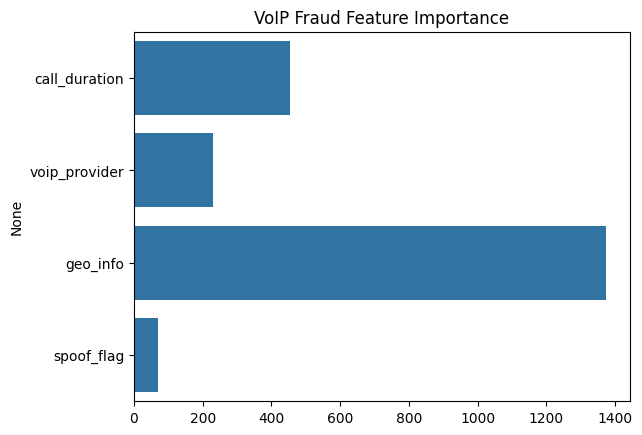

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=features)
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("VoIP Fraud Feature Importance")
plt.show()


In [26]:
import pandas as pd
import joblib
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Load pre-trained models
upi_model = joblib.load("upi_model.pkl")     # Save model earlier using joblib.dump(model, "upi_model.pkl")
voip_model = joblib.load("voip_model.pkl")   # Same for voip

# Load label encoders (used during training)
upi_encoders = joblib.load("upi_label_encoders.pkl")
voip_encoders = joblib.load("voip_label_encoders.pkl")

# --- Example Input Simulated ---
new_upi_txn = pd.DataFrame([{
    "amount": 7800.0,
    "txn_type": "P2P",
    "txn_status": "SUCCESS",
    "location": "North Elizabeth",
    "merchant_code": "M6002"
}])

new_voip_call = pd.DataFrame([{
    "call_duration": 5,
    "voip_provider": "WhatsApp",
    "geo_info": "North Marymouth",
    "spoof_flag": 1
}])

# --- Preprocess UPI input ---
for col in ['txn_type', 'txn_status', 'location', 'merchant_code']:
    new_upi_txn[col] = upi_encoders[col].transform(new_upi_txn[col].astype(str))

# Predict fraud probability
upi_score = upi_model.predict_proba(new_upi_txn)[0][1]

# --- Preprocess VoIP input ---
for col in ['voip_provider', 'geo_info']:
    new_voip_call[col] = voip_encoders[col].transform(new_voip_call[col].astype(str))

voip_score = voip_model.predict_proba(new_voip_call)[0][1]

# --- Final Output ---
print(f"UPI Fraud Score: {upi_score:.2f} {'⚠️ Alert' if upi_score > 0.7 else '✅ Safe'}")
print(f"VoIP Fraud Score: {voip_score:.2f} {'⚠️ Alert' if voip_score > 0.7 else '✅ Safe'}")


UPI Fraud Score: 0.00 ✅ Safe
VoIP Fraud Score: 1.00 ⚠️ Alert
